## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk

In [2]:
import numpy as np
import pandas as pd
import pprint, time
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import math

In [3]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
# top 10 sentences with each word tagged with POS tags in the form of tuples
print(nltk_data[:10])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [5]:
# Splitting into training (95%) and test (5%)
train_set, val_set = train_test_split(nltk_data, test_size=0.05, random_state = 2345)

print("Number of sentences in train dataset: ",len(train_set))
print("Number of sentences in validation dataset: ",len(val_set))
print("Sample train set")
print(train_set[:3])

Number of sentences in train dataset:  3718
Number of sentences in validation dataset:  196
Sample train set
[[('Terms', 'NOUN'), ('were', 'VERB'), ("n't", 'ADV'), ('disclosed', 'VERB'), ('*-1', 'X'), ('.', '.')], [('In', 'ADP'), ('Arizona', 'NOUN'), (',', '.'), ('California', 'NOUN'), (',', '.'), ('Florida', 'NOUN'), (',', '.'), ('Louisiana', 'NOUN'), (',', '.'), ('Maryland', 'NOUN'), (',', '.'), ('New', 'NOUN'), ('Jersey', 'NOUN'), (',', '.'), ('South', 'NOUN'), ('Carolina', 'NOUN'), ('and', 'CONJ'), ('Texas', 'NOUN'), (',', '.'), ('educators', 'NOUN'), ('say', 'VERB'), ('0', 'X'), ('they', 'PRON'), ('are', 'VERB'), ('common', 'ADJ'), ('classroom', 'NOUN'), ('tools', 'NOUN'), ('.', '.')], [('An', 'DET'), ('appeal', 'NOUN'), ('is', 'VERB'), ('expected', 'VERB'), ('*-68', 'X'), ('.', '.')]]


In [6]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95388

In [7]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Terms',
 'were',
 "n't",
 'disclosed',
 '*-1',
 '.',
 'In',
 'Arizona',
 ',',
 'California']

In [8]:
# vocabulary
V = set(tokens)
print(len(V))

12075


In [9]:
#Lets check how many unique POS tags in the corpus

tags =  [pair[1] for pair in train_tagged_words]
T = set(tags)
len(T)

12

### Build the vanilla Viterbi based POS tagger

In [10]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [11]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [12]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [13]:
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

tags_matrix

array([[7.92112276e-02, 1.17981285e-01, 1.38368979e-01, 1.50401071e-02,
        3.14171128e-02, 3.10828872e-02, 7.01871654e-03, 1.29344925e-01,
        6.78475946e-02, 2.30614971e-02, 3.45588237e-01, 1.40374331e-02],
       [1.34961437e-02, 1.64952874e-02, 3.97386476e-02, 6.84447289e-02,
        6.31962270e-02, 3.24443012e-01, 8.56898027e-04, 1.04541562e-01,
        3.24335903e-01, 3.45972590e-02, 8.46186839e-03, 1.39245926e-03],
       [5.26646897e-02, 9.00512263e-02, 9.40954462e-02, 6.62352815e-02,
        8.08843374e-02, 2.21443340e-01, 5.78772351e-02, 4.44863848e-02,
        1.72912732e-01, 2.75006741e-02, 8.93322527e-02, 2.42653000e-03],
       [3.23574729e-02, 2.23420653e-02, 4.23728824e-02, 7.70416018e-03,
        7.31895212e-03, 2.09167957e-01, 5.39291231e-03, 7.20338970e-02,
        1.00154085e-02, 9.24499258e-02, 4.86902922e-01, 1.19414488e-02],
       [2.96296296e-03, 3.34814824e-02, 1.14666663e-01, 1.18518516e-03,
        1.84000000e-01, 3.58222216e-01, 1.36296293e-02, 3.22

In [14]:
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,ADV,ADP,.,PRON,NUM,NOUN,CONJ,ADJ,DET,X,VERB,PRT
ADV,0.079211,0.117981,0.138369,0.015040,0.031417,0.031083,0.007019,0.129345,0.067848,0.023061,0.345588,0.014037
ADP,0.013496,0.016495,0.039739,0.068445,0.063196,0.324443,0.000857,0.104542,0.324336,0.034597,0.008462,0.001392
.,0.052665,0.090051,0.094095,0.066235,0.080884,0.221443,0.057877,0.044486,0.172913,0.027501,0.089332,0.002427
PRON,0.032357,0.022342,0.042373,0.007704,0.007319,0.209168,0.005393,0.072034,0.010015,0.092450,0.486903,0.011941
NUM,0.002963,0.033481,0.114667,0.001185,0.184000,0.358222,0.013630,0.032296,0.003852,0.210963,0.018370,0.026370
NOUN,0.017376,0.177046,0.239724,0.004782,0.009601,0.264583,0.042710,0.012338,0.013142,0.028692,0.146236,0.043769
CONJ,0.054807,0.052485,0.034371,0.057594,0.042267,0.350209,0.000464,0.115653,0.119833,0.007896,0.159313,0.005109
ADJ,0.004302,0.078756,0.067174,0.000662,0.020516,0.698875,0.016545,0.065354,0.005129,0.020185,0.011747,0.010754
DET,0.012226,0.009200,0.017794,0.003632,0.022152,0.639027,0.000484,0.205181,0.005810,0.045273,0.038978,0.000242
X,0.024828,0.143681,0.163864,0.055903,0.002883,0.062310,0.010732,0.017620,0.054942,0.073522,0.204709,0.185007


In [15]:
tags_df.loc['.', :]

ADV     0.052665
ADP     0.090051
.       0.094095
PRON    0.066235
NUM     0.080884
NOUN    0.221443
CONJ    0.057877
ADJ     0.044486
DET     0.172913
X       0.027501
VERB    0.089332
PRT     0.002427
Name: ., dtype: float32

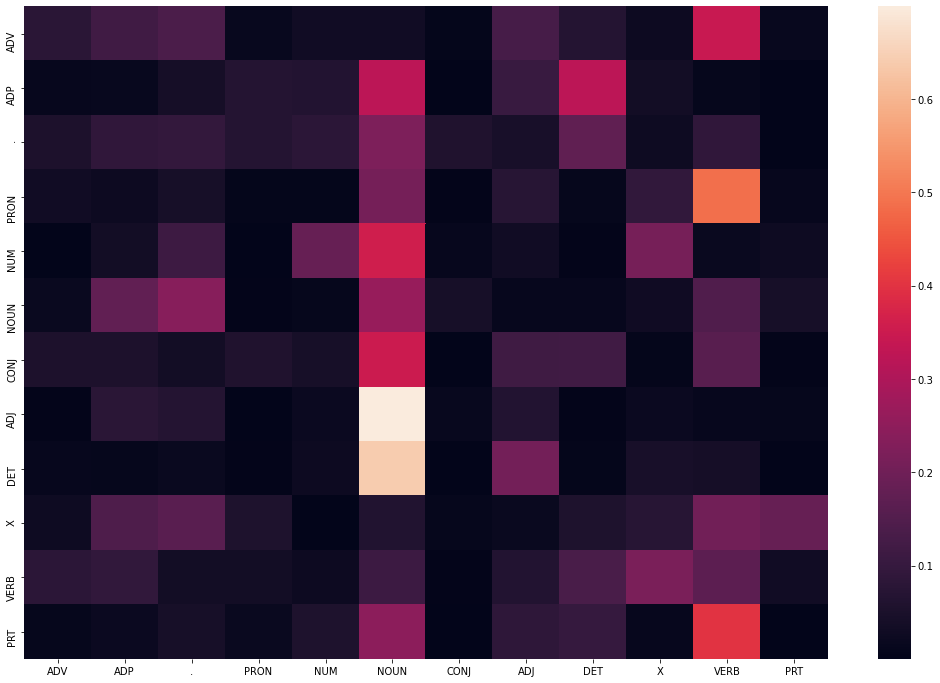

In [16]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

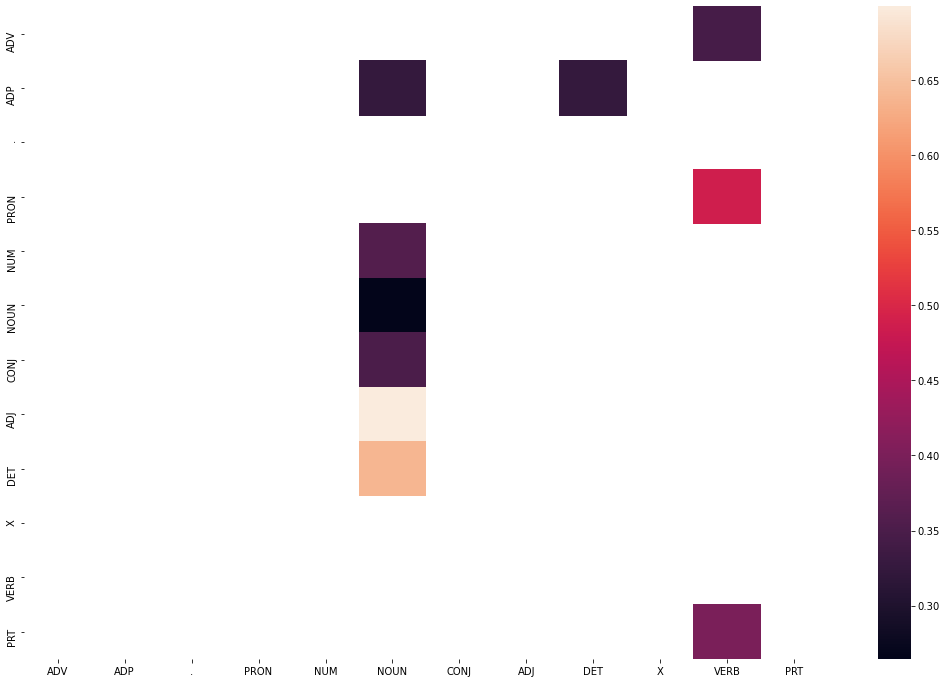

In [17]:
# frequent tags
# filter the df to get P(t2, t1) > 0.25
tags_frequent = tags_df[tags_df>0.25]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [18]:
len(train_tagged_words)

95388

In [19]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [20]:
# list of tagged words
val_run_base = [tup for sent in val_set for tup in sent]

# list of untagged words
val_tagged_words = [tup[0] for sent in val_set for tup in sent]

In [21]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(val_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  2750.7625477313995
[('Bribe', 'ADV'), ('by', 'ADP'), ('bribe', 'ADV'), (',', '.'), ('Mr.', 'NOUN'), ('Sternberg', 'NOUN'), ('and', 'CONJ'), ('his', 'PRON'), ('co-author', 'NOUN'), (',', '.'), ('Matthew', 'ADV'), ('C.', 'NOUN'), ('Harrison', 'ADV'), ('Jr.', 'NOUN'), (',', '.'), ('lead', 'VERB'), ('us', 'PRON'), ('along', 'ADP'), ('the', 'DET'), ('path', 'ADV'), ('0', 'X'), ('Wedtech', 'NOUN'), ('traveled', 'ADV'), ('*T*-1', 'X'), (',', '.'), ('from', 'ADP'), ('its', 'PRON'), ('inception', 'ADV'), ('as', 'ADP'), ('a', 'DET'), ('small', 'ADJ'), ('manufacturing', 'NOUN'), ('company', 'NOUN'), ('to', 'PRT'), ('the', 'DET'), ('status', 'NOUN'), ('of', 'ADP'), ('full-fledged', 'ADV'), ('defense', 'NOUN'), ('contractor', 'NOUN'), (',', '.'), ('entrusted', 'VERB'), ('*', 'X'), ('with', 'ADP'), ('the', 'DET'), ('task', 'NOUN'), ('of', 'ADP'), ('*', 'X'), ('producing', 'VERB'), ('vital', 'ADV'), ('equipment', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Army', 'NOUN'), ('and

In [22]:
# accuracy
check = [i for i, j in zip(tagged_seq, val_run_base) if i == j] 
vannila_viterbi_accuracy = len(check)/len(tagged_seq)
vannila_viterbi_accuracy

0.9103630862329803

In [23]:
incorrect_tagged_cases = [[val_run_base[i-1],j[1]] for i, j in enumerate(zip(tagged_seq, val_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[("''", '.'), ('Bribe', 'NOUN')],
 [('by', 'ADP'), ('bribe', 'NOUN')],
 [(',', '.'), ('Matthew', 'NOUN')],
 [('C.', 'NOUN'), ('Harrison', 'NOUN')],
 [('the', 'DET'), ('path', 'NOUN')],
 [('Wedtech', 'NOUN'), ('traveled', 'VERB')],
 [('its', 'PRON'), ('inception', 'NOUN')],
 [('small', 'ADJ'), ('manufacturing', 'VERB')],
 [('of', 'ADP'), ('full-fledged', 'ADJ')],
 [('producing', 'VERB'), ('vital', 'ADJ')],
 [('.', '.'), ('Brisk', 'ADJ')],
 [('pushed', 'VERB'), ('up', 'PRT')],
 [('solid', 'ADJ'), ('382-37', 'NUM')],
 [('382-37', 'NUM'), ('vote', 'NOUN')],
 [("'s", 'PRT'), ('most', 'ADV')],
 [('of', 'ADP'), ('therapies', 'NOUN')],
 [('in', 'ADP'), ('abortions', 'NOUN')],
 [(',', '.'), ('adverse', 'ADJ')],
 [('.', '.'), ('So', 'ADP')],
 [('bad', 'ADJ'), ('enough', 'ADV')],
 [('to', 'PRT'), ('merit', 'VERB')],
 [('an', 'DET'), ('accelerated', 'VERB')],
 [('special', 'ADJ'), ('301', 'NUM')],
 [('*-2', 'X'), ('punishing', 'VERB')],
 [('or', 'CONJ'), ('retaliating', 'VERB')],
 [('the', 'DET')

In [24]:
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
vannila_test_tagged_seq = tagged_seq

[('Android', 'ADV'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADV'), ('.', '.'), ('Android', 'ADV'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADV'), ('worldwide', 'ADV'), ('on', 'ADP'), ('smartphones', 'ADV'), ('since', 'ADP'), ('2011', 'ADV'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADV'), ('.', '.'), ('Google', 'ADV'), ('and', 'CONJ'), ('Twitter', 'ADV'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADV'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADV'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADV'), ("'s", 'PRT'), ('firehose', 'ADV'), ('.', '.'), ('Twitter', 'ADV'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADV'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOU

In [25]:
# vocabulary in test set
voc_val_set = set(val_tagged_words)

# Unknown words in val set
unknown_words = (voc_val_set-V)
print(unknown_words)

{'refer', 'ceramic', 'higher-salaried', 'soybeans', 'newer', 'despised', 'issuer', 'Honolulu', 'asbestosis', 'alerts', 'reap', 'skittishness', 'inventory', '*T*-113', '1933', 'Brisk', 'sub-markets', 'Attorneys', 'unproven', 'participated', 'attended', 'ranging', 'affirmative', '*T*-96', 'TRUST', 'outlawed', 'Milan', 'punishing', 'Destinations', 'unethical', 'READY', 'inadequacy', 'life-style', '240-page', 'Session', 'Jovanovich', 'Recess', 'outlays', 'researching', 'equal-opportunity', '26,956', 'MERRILL', 'Miklos', '1968', 'wedded', 'Countries', 'cards', 'hypocrisy', 'craft', 'defeats', 'Harrison', '1.17', 'prosecutor', 'YMCA', 'reimbursed', 'Again', '1990-91', '129.91', 'Gross', 'Schaefer', 'inkling', 'expands', 'single-A', 'fueling', 'malignant', 'casino', '331,000', 'Pardus', 'rim', 'mortgage-based', 'inception', 'automobile', 'slash', 'stemmed', 'universities', '397', 'cattle', 'hailed', 'specialize', 'milked', 'entrench', 'Long-term', 'halve', 'Brussels', 'proponent', 'inaccurate

### Solve the problem of unknown words

#### Technique 1:

1. If word, in training corpus, state probability = emission probability * transition probability
2. If word not in training corpus, using rule based tagger for unknown words using morphological rules.

In [26]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*er$', 'ADJ'),                # adjectives
    (r'.*est$', 'ADJ'),               # adjectives
    (r'.*able$', 'ADJ'),              # adjectives
    (r'.*ly$', 'ADV'),                # adverbs
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'(The|the|A|a|An|an)$', 'DET'), # articles
    (r'.*', 'NOUN')                   # nouns
]
regexp_tagger = nltk.RegexpTagger(patterns)

In [27]:
# Modified Viterbi Heuristic with rule based technique
def Modified_Viterbi_1(words, train_bag = train_tagged_words, vocabulary=V):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        state_max = 'NOUN'
        if (word in vocabulary):
            #initialise list of probability column for a given observation
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)

            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        else: 
            # Rule based tagging
            pos_tag = regexp_tagger.tag([word])
            state_max = pos_tag[0][1]
            
        state.append(state_max)
    return list(zip(words, state))

In [28]:
# tagging the test sentences
start = time.time()
rule_based_tagged_seq = Modified_Viterbi_1(val_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(rule_based_tagged_seq)

Time taken in seconds:  1974.0176763534546
[('Bribe', 'NOUN'), ('by', 'ADP'), ('bribe', 'NOUN'), (',', '.'), ('Mr.', 'NOUN'), ('Sternberg', 'NOUN'), ('and', 'CONJ'), ('his', 'PRON'), ('co-author', 'NOUN'), (',', '.'), ('Matthew', 'NOUN'), ('C.', 'NOUN'), ('Harrison', 'NOUN'), ('Jr.', 'NOUN'), (',', '.'), ('lead', 'VERB'), ('us', 'PRON'), ('along', 'ADP'), ('the', 'DET'), ('path', 'NOUN'), ('0', 'X'), ('Wedtech', 'NOUN'), ('traveled', 'VERB'), ('*T*-1', 'X'), (',', '.'), ('from', 'ADP'), ('its', 'PRON'), ('inception', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('small', 'ADJ'), ('manufacturing', 'NOUN'), ('company', 'NOUN'), ('to', 'PRT'), ('the', 'DET'), ('status', 'NOUN'), ('of', 'ADP'), ('full-fledged', 'VERB'), ('defense', 'NOUN'), ('contractor', 'NOUN'), (',', '.'), ('entrusted', 'VERB'), ('*', 'X'), ('with', 'ADP'), ('the', 'DET'), ('task', 'NOUN'), ('of', 'ADP'), ('*', 'X'), ('producing', 'VERB'), ('vital', 'NOUN'), ('equipment', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Army', 'NOUN

#### Technique 2:

1. If word, in training corpus, state probability = emission probability * transition probability
2. If word, not in training corpus, state probability = transition probability

In [29]:
# Viterbi Heuristic backed off with probability technique
def Modified_Viterbi_2(words, train_bag = train_tagged_words, vocabulary=V):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            if (word in vocabulary):
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            else:
                emission_p = 0.001
            
            state_probability = emission_p * transition_p
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [30]:
# tagging the test sentences
start = time.time()
probability_tagged_seq = Modified_Viterbi_2(val_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(probability_tagged_seq)

Time taken in seconds:  1250.3503549098969
[('Bribe', 'NOUN'), ('by', 'ADP'), ('bribe', 'NOUN'), (',', '.'), ('Mr.', 'NOUN'), ('Sternberg', 'NOUN'), ('and', 'CONJ'), ('his', 'PRON'), ('co-author', 'NOUN'), (',', '.'), ('Matthew', 'NOUN'), ('C.', 'NOUN'), ('Harrison', 'NOUN'), ('Jr.', 'NOUN'), (',', '.'), ('lead', 'VERB'), ('us', 'PRON'), ('along', 'ADP'), ('the', 'DET'), ('path', 'NOUN'), ('0', 'X'), ('Wedtech', 'NOUN'), ('traveled', 'NOUN'), ('*T*-1', 'X'), (',', '.'), ('from', 'ADP'), ('its', 'PRON'), ('inception', 'VERB'), ('as', 'ADP'), ('a', 'DET'), ('small', 'ADJ'), ('manufacturing', 'NOUN'), ('company', 'NOUN'), ('to', 'PRT'), ('the', 'DET'), ('status', 'NOUN'), ('of', 'ADP'), ('full-fledged', 'NOUN'), ('defense', 'NOUN'), ('contractor', 'NOUN'), (',', '.'), ('entrusted', 'VERB'), ('*', 'X'), ('with', 'ADP'), ('the', 'DET'), ('task', 'NOUN'), ('of', 'ADP'), ('*', 'X'), ('producing', 'VERB'), ('vital', 'X'), ('equipment', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Army', 'NOUN'),

#### Evaluating tagging accuracy

In [31]:
print('Test Accuracy by baseline Viterbi: ', vannila_viterbi_accuracy)

Test Accuracy by baseline Viterbi:  0.9103630862329803


In [32]:
# accuracy
check = [i for i, j in zip(rule_based_tagged_seq, val_run_base) if i == j] 
rule_based_viterbi_accuracy = len(check)/len(rule_based_tagged_seq)
rule_based_viterbi_accuracy

0.954803328290469

In [33]:
# accuracy
check = [i for i, j in zip(probability_tagged_seq, val_run_base) if i == j] 
probability_viterbi_accuracy = len(check)/len(probability_tagged_seq)
probability_viterbi_accuracy

0.9406202723146747

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

#### Accuracies:

1. The accuracy of Vanilla Veterbi POS tagger on Validation dataset : 90.8%
1. The accuracy of Rule based Veterbi POS tagger on Validation dataset : 95.4%
1. The accuracy of Probabilistic Veterbi POS tagger on Validation dataset : 94.06%

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [34]:
incorrect_tagged_cases

[[("''", '.'), ('Bribe', 'NOUN')],
 [('by', 'ADP'), ('bribe', 'NOUN')],
 [(',', '.'), ('Matthew', 'NOUN')],
 [('C.', 'NOUN'), ('Harrison', 'NOUN')],
 [('the', 'DET'), ('path', 'NOUN')],
 [('Wedtech', 'NOUN'), ('traveled', 'VERB')],
 [('its', 'PRON'), ('inception', 'NOUN')],
 [('small', 'ADJ'), ('manufacturing', 'VERB')],
 [('of', 'ADP'), ('full-fledged', 'ADJ')],
 [('producing', 'VERB'), ('vital', 'ADJ')],
 [('.', '.'), ('Brisk', 'ADJ')],
 [('pushed', 'VERB'), ('up', 'PRT')],
 [('solid', 'ADJ'), ('382-37', 'NUM')],
 [('382-37', 'NUM'), ('vote', 'NOUN')],
 [("'s", 'PRT'), ('most', 'ADV')],
 [('of', 'ADP'), ('therapies', 'NOUN')],
 [('in', 'ADP'), ('abortions', 'NOUN')],
 [(',', '.'), ('adverse', 'ADJ')],
 [('.', '.'), ('So', 'ADP')],
 [('bad', 'ADJ'), ('enough', 'ADV')],
 [('to', 'PRT'), ('merit', 'VERB')],
 [('an', 'DET'), ('accelerated', 'VERB')],
 [('special', 'ADJ'), ('301', 'NUM')],
 [('*-2', 'X'), ('punishing', 'VERB')],
 [('or', 'CONJ'), ('retaliating', 'VERB')],
 [('the', 'DET')

In [35]:
rule_based_correct_tagged_cases = [[val_run_base[i-1],j[1]] for i, j in enumerate(zip(rule_based_tagged_seq, val_run_base)) 
                                    if j[0]==j[1]]

In [36]:
corrections_rule_based_Viterbi = [x for x in rule_based_correct_tagged_cases if x in incorrect_tagged_cases]
corrections_rule_based_Viterbi

[[("''", '.'), ('Bribe', 'NOUN')],
 [('by', 'ADP'), ('bribe', 'NOUN')],
 [(',', '.'), ('Matthew', 'NOUN')],
 [('C.', 'NOUN'), ('Harrison', 'NOUN')],
 [('the', 'DET'), ('path', 'NOUN')],
 [('Wedtech', 'NOUN'), ('traveled', 'VERB')],
 [('its', 'PRON'), ('inception', 'NOUN')],
 [('solid', 'ADJ'), ('382-37', 'NUM')],
 [('382-37', 'NUM'), ('vote', 'NOUN')],
 [('in', 'ADP'), ('abortions', 'NOUN')],
 [('special', 'ADJ'), ('301', 'NUM')],
 [('*-2', 'X'), ('punishing', 'VERB')],
 [('or', 'CONJ'), ('retaliating', 'VERB')],
 [('the', 'DET'), ('newer', 'ADJ')],
 [('a', 'DET'), ('bargain', 'NOUN')],
 [('the', 'DET'), ('Purepac', 'NOUN')],
 [('Purepac', 'NOUN'), ('label', 'NOUN')],
 [('Donald', 'NOUN'), ('Pardus', 'NOUN')],
 [('.', '.'), ('Centerbank', 'NOUN')],
 [('of', 'ADP'), ('NESB', 'NOUN')],
 [('and', 'CONJ'), ('life-style', 'NOUN')],
 [('numerous', 'ADJ'), ('sub-markets', 'NOUN')],
 [('.', '.'), ('Paris', 'NOUN')],
 [(',', '.'), ('Brussels', 'NOUN')],
 [('and', 'CONJ'), ('Milan', 'NOUN')],
 [

In [37]:
probability_correct_tagged_cases = [[val_run_base[i-1],j[1]] for i, j in enumerate(zip(probability_tagged_seq, val_run_base))
                                      if j[0]==j[1]]

In [38]:
corrections_probability_Viterbi = [x for x in probability_correct_tagged_cases if x in incorrect_tagged_cases]
corrections_probability_Viterbi

[[("''", '.'), ('Bribe', 'NOUN')],
 [('by', 'ADP'), ('bribe', 'NOUN')],
 [(',', '.'), ('Matthew', 'NOUN')],
 [('C.', 'NOUN'), ('Harrison', 'NOUN')],
 [('the', 'DET'), ('path', 'NOUN')],
 [('382-37', 'NUM'), ('vote', 'NOUN')],
 [('of', 'ADP'), ('therapies', 'NOUN')],
 [('in', 'ADP'), ('abortions', 'NOUN')],
 [('*-2', 'X'), ('punishing', 'VERB')],
 [('a', 'DET'), ('bargain', 'NOUN')],
 [('the', 'DET'), ('Purepac', 'NOUN')],
 [('Purepac', 'NOUN'), ('label', 'NOUN')],
 [('Donald', 'NOUN'), ('Pardus', 'NOUN')],
 [('.', '.'), ('Centerbank', 'NOUN')],
 [('of', 'ADP'), ('NESB', 'NOUN')],
 [('and', 'CONJ'), ('life-style', 'NOUN')],
 [('numerous', 'ADJ'), ('sub-markets', 'NOUN')],
 [('.', '.'), ('Paris', 'NOUN')],
 [(',', '.'), ('Brussels', 'NOUN')],
 [('and', 'CONJ'), ('Milan', 'NOUN')],
 [('it', 'PRON'), ('resists', 'VERB')],
 [('.', '.'), ('Activity', 'NOUN')],
 [('.', '.'), ('Part', 'NOUN')],
 [('of', 'ADP'), ('jitters', 'NOUN')],
 [('.', '.'), ('Attorneys', 'NOUN')],
 [('Johnson', 'NOUN'), 

### Testing on test file

In [39]:
vannila_test_tagged_seq

[('Android', 'ADV'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'ADV'),
 ('.', '.'),
 ('Android', 'ADV'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'ADV'),
 ('worldwide', 'ADV'),
 ('on', 'ADP'),
 ('smartphones', 'ADV'),
 ('since', 'ADP'),
 ('2011', 'ADV'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'ADV'),
 ('.', '.'),
 ('Google', 'ADV'),
 ('and', 'CONJ'),
 ('Twitter', 'ADV'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'ADV'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'ADV'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'ADV'),
 ("'s", 'PRT'),
 ('firehose', 'ADV'),
 ('.', '.'),
 ('Twitter', 'ADV'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'ADV'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOU

In [40]:
start = time.time()
rule_based_test_tagged_seq = Modified_Viterbi_1(words)
end = time.time()
difference = end-start

print(rule_based_test_tagged_seq)
print(difference)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'ADJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADJ'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'ADJ'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('us

In [41]:
# Tags which corrected in rule based approach
corrected_tag_rule_base = [j for i, j in enumerate(zip(vannila_test_tagged_seq, rule_based_test_tagged_seq)) if(j[0]!= j[1])]
# [old_tag, new_tag]
corrected_tag_rule_base

[(('Android', 'ADV'), ('Android', 'NOUN')),
 (('Google', 'ADV'), ('Google', 'NOUN')),
 (('Android', 'ADV'), ('Android', 'NOUN')),
 (('OS', 'ADV'), ('OS', 'NOUN')),
 (('worldwide', 'ADV'), ('worldwide', 'NOUN')),
 (('smartphones', 'ADV'), ('smartphones', 'VERB')),
 (('2011', 'ADV'), ('2011', 'NUM')),
 (('2013', 'ADV'), ('2013', 'NUM')),
 (('Google', 'ADV'), ('Google', 'NOUN')),
 (('Twitter', 'ADV'), ('Twitter', 'ADJ')),
 (('2015', 'ADV'), ('2015', 'NUM')),
 (('Google', 'ADV'), ('Google', 'NOUN')),
 (('Twitter', 'ADV'), ('Twitter', 'ADJ')),
 (('firehose', 'ADV'), ('firehose', 'NOUN')),
 (('Twitter', 'ADV'), ('Twitter', 'ADJ')),
 (('online', 'ADV'), ('online', 'NOUN')),
 (('interact', 'ADV'), ('interact', 'NOUN')),
 (('messages', 'ADV'), ('messages', 'VERB')),
 (('tweets', 'ADV'), ('tweets', 'NOUN')),
 (('domineering', 'ADV'), ('domineering', 'VERB')),
 (('personality', 'ADV'), ('personality', 'NOUN')),
 (('2018', 'ADV'), ('2018', 'NUM')),
 (('FIFA', 'ADV'), ('FIFA', 'NOUN')),
 (('Cup', '

In [42]:
start = time.time()
probabilty_test_tagged_seq = Modified_Viterbi_2(words)
end = time.time()
difference = end-start

print(probabilty_test_tagged_seq)
print(difference)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), (

In [43]:
# Tags which corrected in probabilistic approach
corrected_tag_probabilty = [j for i, j in enumerate(zip(vannila_test_tagged_seq, probabilty_test_tagged_seq)) if(j[0]!= j[1])]
# [old_tag, new_tag]
corrected_tag_probabilty

[(('Android', 'ADV'), ('Android', 'NOUN')),
 (('Google', 'ADV'), ('Google', 'NOUN')),
 (('Android', 'ADV'), ('Android', 'NOUN')),
 (('OS', 'ADV'), ('OS', 'NOUN')),
 (('worldwide', 'ADV'), ('worldwide', 'NOUN')),
 (('smartphones', 'ADV'), ('smartphones', 'NOUN')),
 (('2011', 'ADV'), ('2011', 'NOUN')),
 (('2013', 'ADV'), ('2013', 'NOUN')),
 (('Google', 'ADV'), ('Google', 'NOUN')),
 (('Twitter', 'ADV'), ('Twitter', 'NOUN')),
 (('2015', 'ADV'), ('2015', 'NOUN')),
 (('Google', 'ADV'), ('Google', 'X')),
 (('Twitter', 'ADV'), ('Twitter', 'VERB')),
 (('firehose', 'ADV'), ('firehose', 'VERB')),
 (('Twitter', 'ADV'), ('Twitter', 'NOUN')),
 (('online', 'ADV'), ('online', 'NOUN')),
 (('interact', 'ADV'), ('interact', 'NOUN')),
 (('messages', 'ADV'), ('messages', 'NOUN')),
 (('tweets', 'ADV'), ('tweets', 'NOUN')),
 (('domineering', 'ADV'), ('domineering', 'NOUN')),
 (('personality', 'ADV'), ('personality', 'NOUN')),
 (('2018', 'ADV'), ('2018', 'NOUN')),
 (('FIFA', 'ADV'), ('FIFA', 'NOUN')),
 (('Cup